In [314]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import math
import random

In [315]:
rcParams['figure.figsize'] = [12, 10]
rcParams['font.size'] = 18

In [2]:
def wf(x, alpha=1, **kwargs):
    return np.exp( -alpha * x**2 )**2

In [3]:
def mcmc(prob, initial_location, draw, funcs=[], num_iter=10000, **kwargs):
    results = [[] for i in range(len(funcs))]
    
    location = initial_location
    
    locations = []
    
    for i in range(num_iter):
        for j, func in enumerate(funcs):
            results[j].append(func(location, **kwargs))
        
        # Record where we are
        prev_prob = prob(location, **kwargs)
        
        # Propose update
        next_location = draw(location, **kwargs)
        next_prob = prob(next_location, **kwargs)
        
        if type(location) == np.ndarray:
            where_to_update = np.random.uniform(0, 1, len(initial_location))
            move = np.where(next_prob / prev_prob > where_to_update)
            # Accept update
            location[move] = next_location[move]
        else:
            if next_prob / prev_prob > random.uniform(0, 1):
                # Accept update
                location = next_location
        
        locations.append(np.copy(location))
        
    return np.array(locations), np.array(results)

In [15]:
def draw(x, eps=0.1, **kwargs):
    if type(x) == np.ndarray:
        return np.random.uniform(x - eps, x + eps, len(x))
    else:
        return random.uniform(x - eps, x + eps)

In [5]:
def energy(x, alpha=1, **kwargs):
    return alpha + x**2 * (0.5 - 2 * alpha**2)

In [114]:
chains = []
energies = []
alphas = np.linspace(0.15, 1.8, 100)

for alpha in alphas:
    chain, result = mcmc(wf, 1, draw, funcs=[energy], num_iter=200000, alpha=alpha, eps=0.1)
    chains.append(np.array(chain))
    energies.append(np.array(result[0]))

In [115]:
def update_alpha(alpha, gamma, deriv):
    return alpha - gamma * deriv

In [47]:
chains = []
energies = []
results = []
alphas = np.linspace(0.10, 1.8, 40)

num_walkers = 1000

for alpha in alphas:
    chain, result = mcmc(wf, np.random.uniform(-1, 1, size=num_walkers), draw, funcs=[energy], num_iter=10000, alpha=alpha, eps=0.1)
    results.append(result)
    energies.append(np.hstack(result[0]))

Text(0,0.5,'$\\langle E^2 \\rangle - \\langle E \\rangle^2$')

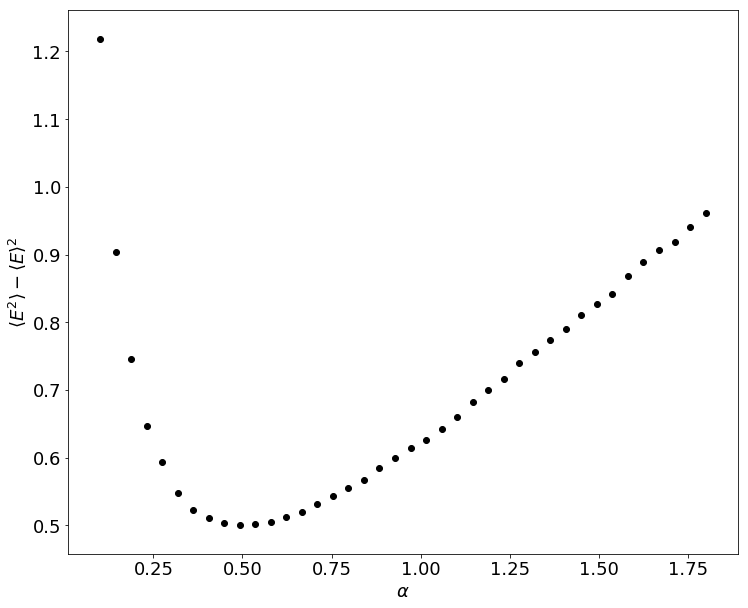

In [324]:
plt.scatter(alphas, [np.mean(energies[i]) for i in range(len(energies))], color='k')

plt.xlabel(r'$\alpha$')
plt.ylabel(r"$\langle E^2 \rangle - \langle E \rangle^2$")

plt.show()

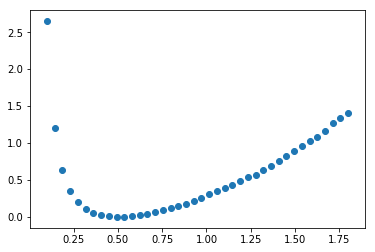

In [79]:
energies_squared = [energies[i]**2 for i in range(len(energies))]
square_energies = [np.mean(energies[i])**2 for i in range(len(energies))]
mean_energies_squared = [np.mean(energies_squared[i]) for i in range(len(energies))]

y = np.array(mean_energies_squared) - np.array(square_energies)

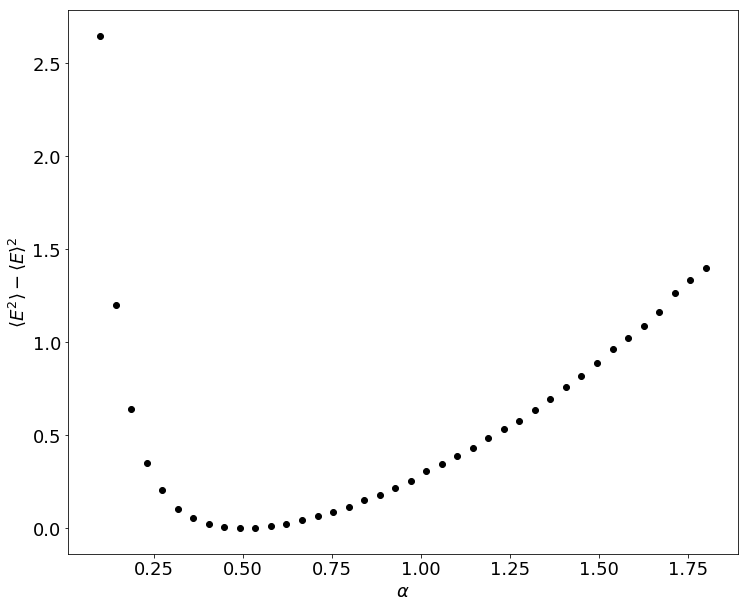

In [325]:
plt.xlabel(r'$\alpha$')
plt.ylabel(r"$\langle E^2 \rangle - \langle E \rangle^2$")

plt.scatter(alphas, y, color='k')

plt.show()

# Part 2

In [299]:
def DMC(walkers, delta_tau, E_t, alpha, M_t, num_iter=100):
    for i in range(num_iter):
        num_walkers = len(walkers)
        
        walkers += math.sqrt(delta_tau) * np.random.normal(size=(num_walkers, 3))

        V = np.linalg.norm(walkers, axis=1)**2 / 2
        
        W = np.exp(delta_tau * (E_t - V))
        s = np.floor(W).astype(int)
        r = np.random.uniform(size=len(s))
        
        update = np.where(r < W - s)
        s[update] = s[update] + 1

        stay = np.where(s > 0)

        more = np.where(s > 1)[0]

        new_walkers = []
        for idx in more:
            num_new_walkers = s[idx] - 1
            for j in range(num_new_walkers):
                new_walkers.append(walkers[idx].copy())

        if len(new_walkers) != 0:
            walkers = np.concatenate((walkers[stay], new_walkers))
        else:
            walkers = walkers[stay]

        if len(walkers) > 0:
            E_t = E_t + alpha * np.log(M_t / len(walkers))
        else:
            print("Out of walkers!")
            break
            
    return walkers

In [306]:
walkers = np.random.uniform(size=(10000, 3))
delta_tau = 0.01
E_t = 1
alpha = 0.01
M_t = 1e5

res_walkers = DMC(walkers, delta_tau, E_t, alpha, M_t, num_iter=300)

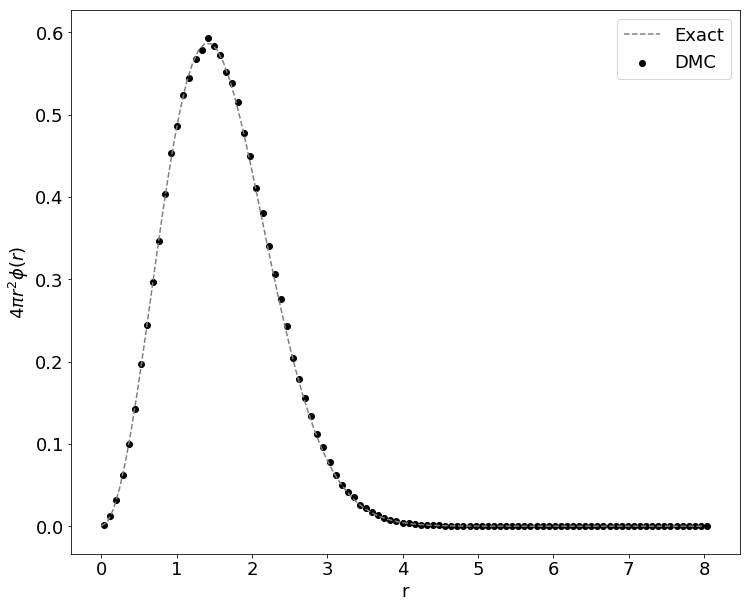

In [323]:
heights, bins, _ = plt.hist(np.linalg.norm(res_walkers, axis=1), bins=100, range=(0, 8), normed=True, align='mid')
plt.close()
r = np.linspace(0, 8, 100)
plt.plot(r, 4 * np.pi * r**2 * np.exp(- r**2 / 2) / (2* np.pi)**(3/2), color='gray', linestyle='--', label='Exact')
plt.scatter(r + (bins[1] - bins[0])/2, heights, color='k', label='DMC')

plt.xlabel("r")
plt.ylabel(r"$4\pi r^2 \phi\left(r\right)$")

plt.legend()
plt.show()